%pip install scipy

%pip install matplotlib

In [42]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.stats import truncnorm
from scipy.stats import chi2_contingency
import scipy.stats as stats


# 1. Selección de Dataset Original

Seleccionen un dataset de Kaggle con las siguientes características:
- Contiene variables categóricas y numéricas.
- Es posible simular la expansión de registros usando las probabilidades de 
ocurrencia de las categorías.
- Asegúrense de elegir un dataset con al menos 500 registros.

## Leer dataset

In [43]:
df = pd.read_csv("Depression Student Dataset.csv")

## Analizar los tipos de datos

In [44]:
df.columns = df.columns.str.lower()

In [45]:
df.dtypes

gender                                    object
age                                        int64
academic pressure                        float64
study satisfaction                       float64
sleep duration                            object
dietary habits                            object
have you ever had suicidal thoughts ?     object
study hours                                int64
financial stress                           int64
family history of mental illness          object
depression                                object
dtype: object

## Renombrando las columnas

In [46]:
df.columns = ['gender','age','academic_pressure','study_satisfaction','sleep_duration','dietary_habits','suicidal_thoughts','study_hours','financial_stress','family_history','depression' ]

## Agregando ID a los usuarios

In [47]:
df['individual'] = range(1, len(df) + 1)


# 2. Análisis Exploratorio de Datos (EDA)
 Realicen un EDA completo en el dataset original, incluyendo:
 - Estadísticas descriptivas para las variables numéricas.
 - Distribuciones de las categorías principales.
 - Visualización de correlaciones entre variables.
 

Con base en los resultados de este análisis, seleccionen las variables categóricas 
que utilizarán en el paso de simulación. No es necesario usar todas las variables 
categóricas; elijan las que sean más relevantes.

## Estadisticas descriptivas para las variables numéricas

In [48]:
num_cols = []

for c in df.columns:
    if (df[c].dtype == 'int64' or df[c].dtype =='float64'):    
        num_cols.append(c)

num_cols

['age',
 'academic_pressure',
 'study_satisfaction',
 'study_hours',
 'financial_stress',
 'individual']

In [49]:
num_cols_df = pd.DataFrame(df[num_cols])
num_cols_df.head(2)

,age,academic_pressure,study_satisfaction,study_hours,financial_stress,individual
0,28,2.0,4.0,9,2,1
1,28,4.0,5.0,7,1,2


In [50]:
num_cols_df.describe()

,age,academic_pressure,study_satisfaction,study_hours,financial_stress,individual
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,26.241036,3.003984,3.075697,6.404382,2.928287,251.500000
std,4.896501,1.390007,1.373490,3.742434,1.425053,145.059183
min,18.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,22.000000,2.000000,2.000000,3.000000,2.000000,126.250000
50%,26.500000,3.000000,3.000000,7.000000,3.000000,251.500000
75%,30.000000,4.000000,4.000000,10.000000,4.000000,376.750000
max,34.000000,5.000000,5.000000,12.000000,5.000000,502.000000


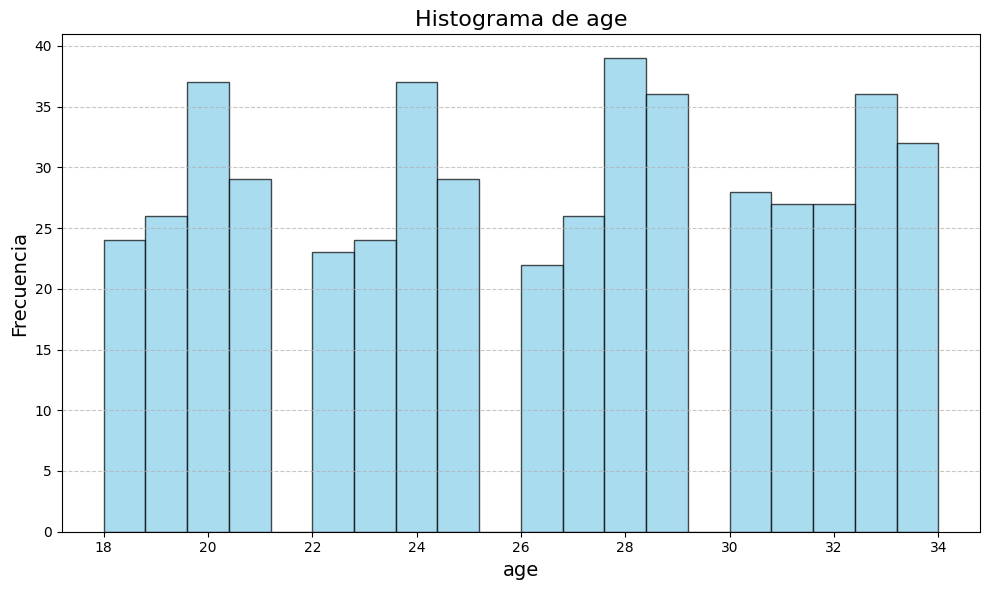

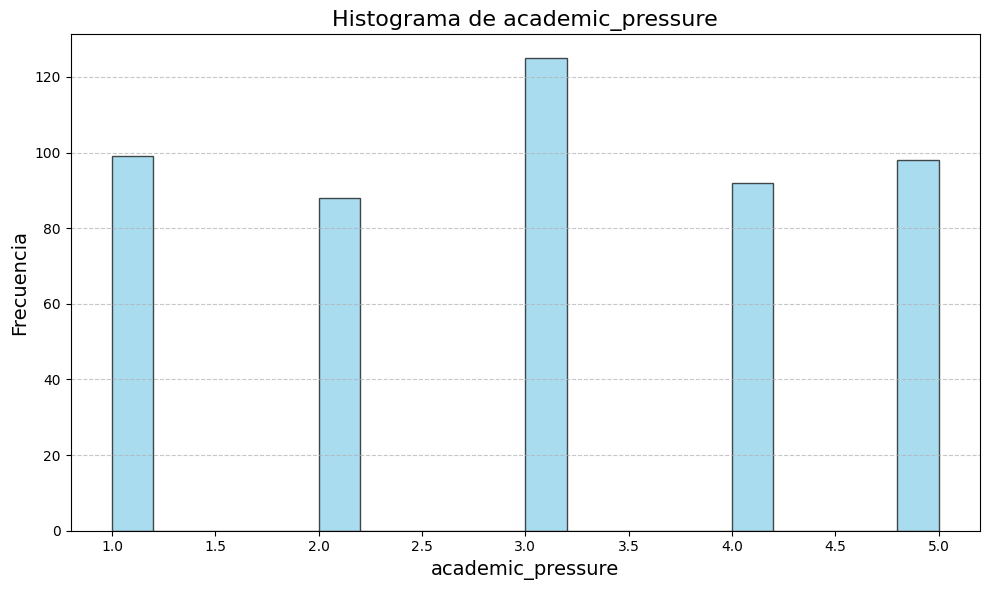

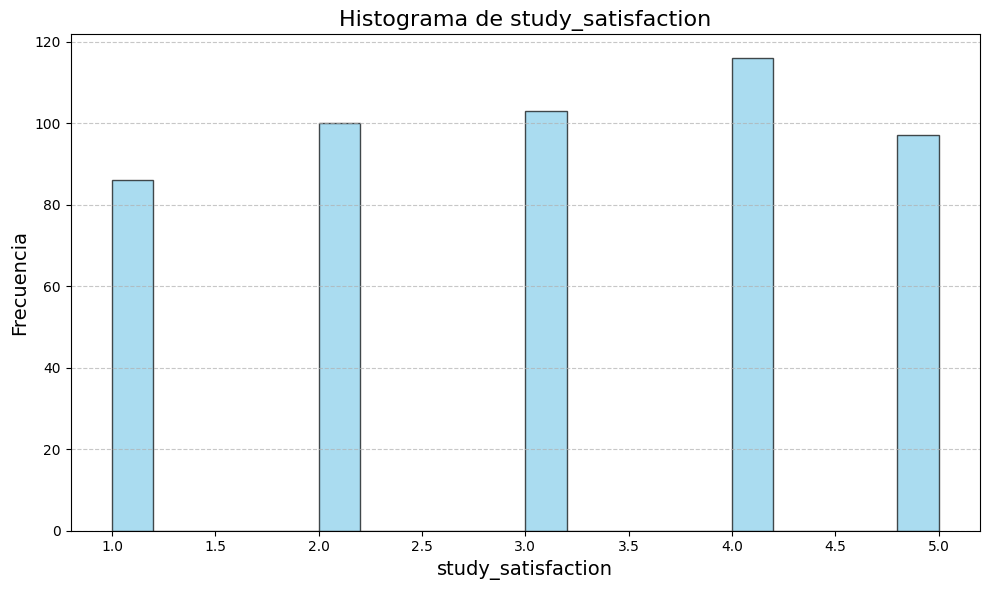

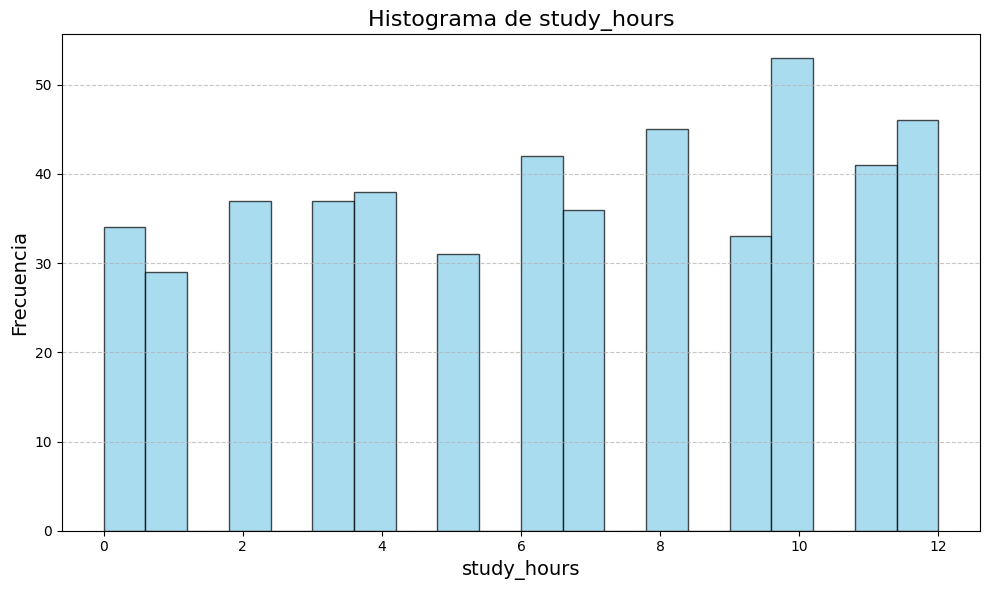

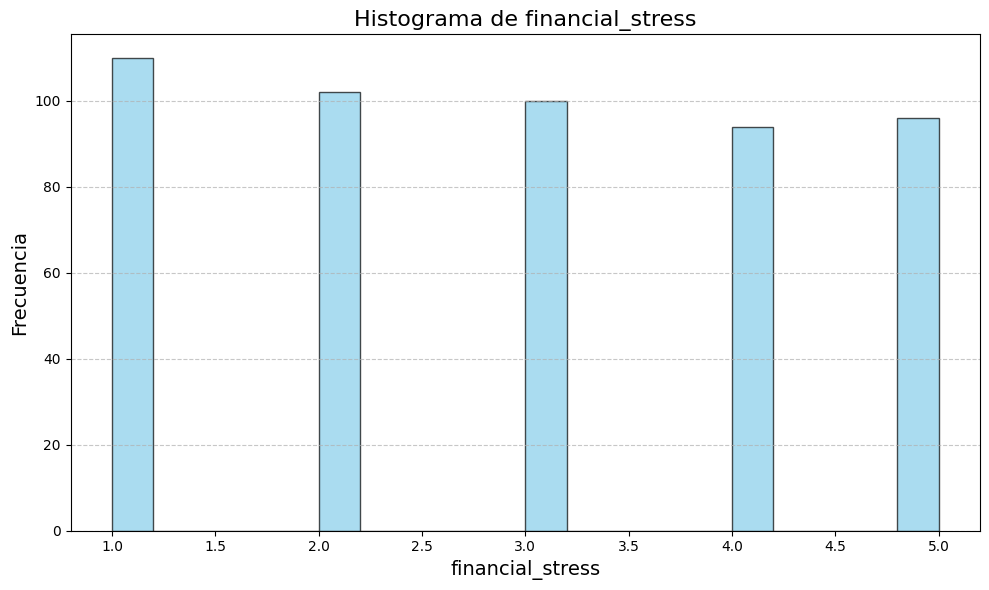

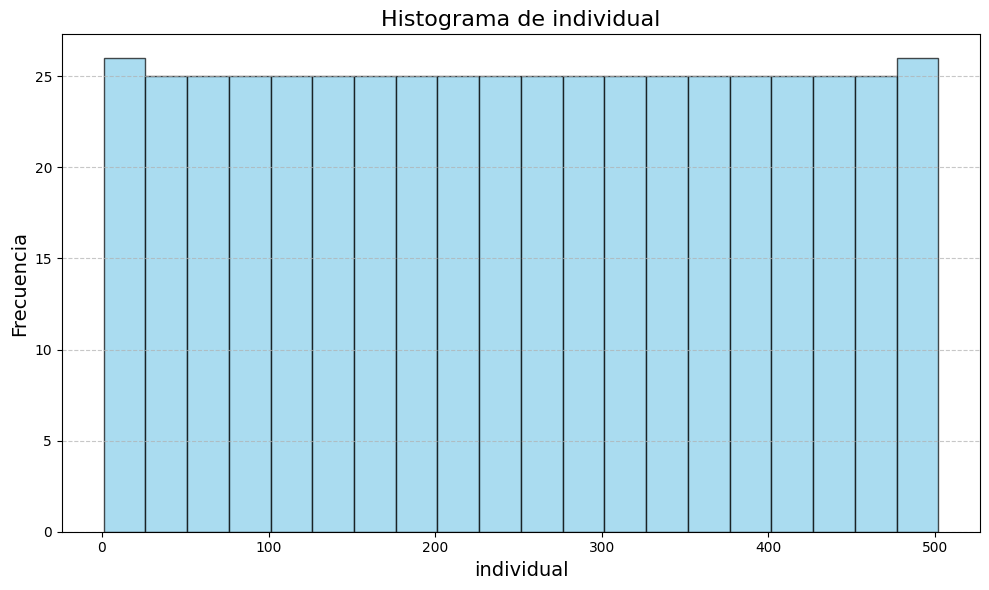

In [51]:
for num_col in num_cols_df.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(df[num_col], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

    plt.title(f'Histograma de {num_col}', fontsize=16)
    plt.xlabel(f'{num_col}', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


## Distribuciones de las categorías principales

In [52]:
cat_cols = []

for c in df.columns:
    if df[c].dtype == 'object':
        cat_cols.append(c)

cat_cols

['gender',
 'sleep_duration',
 'dietary_habits',
 'suicidal_thoughts',
 'family_history',
 'depression']

## Visualización de correlación entre variables

Dado que nuestro target es la depresión en los estudiantes, aplicamos la prueba Chi Cuadrado a esta variable para saber cuáles son las variables categóricas más influyentes.

In [53]:
chi2_results = {}
for col in cat_cols:
    contingency = pd.crosstab(df[col], df['depression'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results[col] = {'chi2': chi2, 'p_value': p}

chi2_df = pd.DataFrame(chi2_results)
chi2_df

,gender,sleep_duration,dietary_habits,suicidal_thoughts,family_history,depression
chi2,0.384930,2.211071,18.069215,1.072925e+02,1.362454,4.980079e+02
p_value,0.534977,0.529771,0.000119,3.840861e-25,0.243113,2.578765e-110


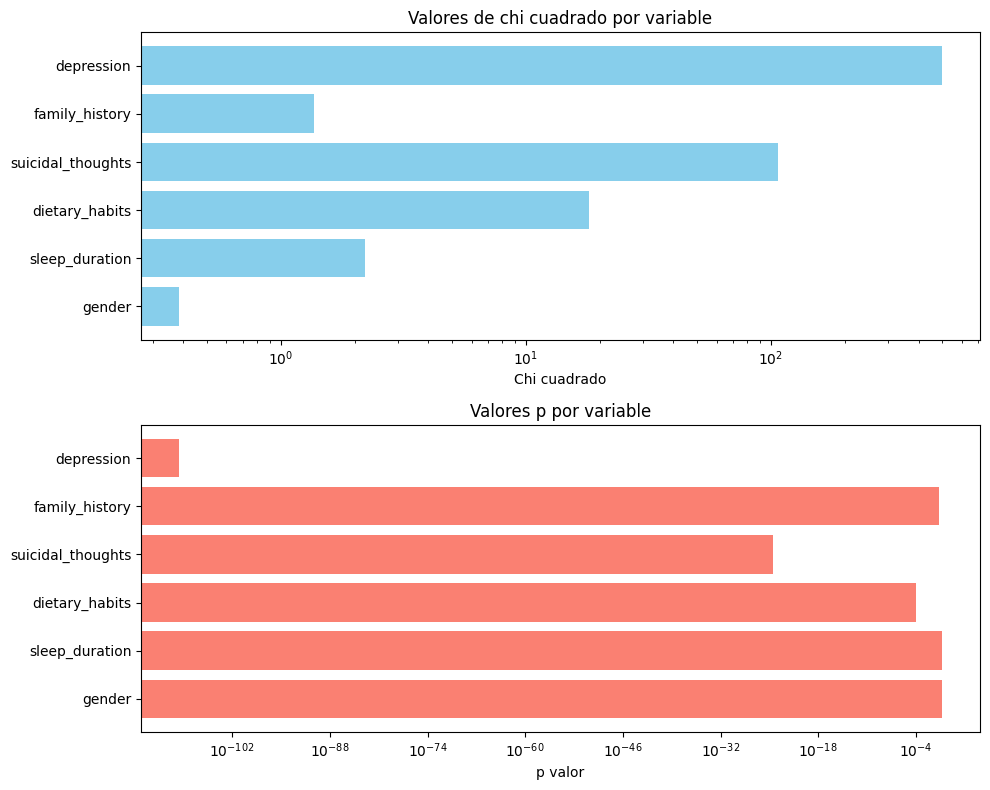

In [54]:
variables = [x[0] for x in chi2_results.items()]
p_values = [x[1]['p_value'] for x in chi2_results.items()]
chi2_values = [x[1]['chi2'] for x in chi2_results.items()]

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].barh(variables, chi2_values, color='skyblue')
ax[0].set_title('Valores de chi cuadrado por variable')
ax[0].set_xlabel('Chi cuadrado')
ax[0].set_xscale('log')

ax[1].barh(variables, p_values, color='salmon')
ax[1].set_title('Valores p por variable')
ax[1].set_xlabel('p valor')
ax[1].set_xscale('log')

plt.tight_layout()
plt.show()

Eliminamos las variables categóricas menos importantes para nuestro estudio:

In [55]:
cat_cols.remove('gender')
cat_cols.remove('sleep_duration')
cat_cols

['dietary_habits', 'suicidal_thoughts', 'family_history', 'depression']

## Agrupaciones para obtener las distribuciones probabilísticas de las categorías principales

In [56]:
prob_freq = df.groupby(cat_cols, as_index = False).agg({
    "individual" : ["count"]
})

prob_freq.columns = cat_cols + ['individuals']
prob_freq['individuals'] = prob_freq['individuals'] / df.shape[0]
prob_freq

,dietary_habits,suicidal_thoughts,family_history,depression,individuals
0,Healthy,No,No,No,0.069721
1,Healthy,No,No,Yes,0.011952
2,Healthy,No,Yes,No,0.067729
3,Healthy,No,Yes,Yes,0.015936
4,Healthy,Yes,No,No,0.033865
5,Healthy,Yes,No,Yes,0.041833
6,Healthy,Yes,Yes,No,0.021912
7,Healthy,Yes,Yes,Yes,0.057769
8,Moderate,No,No,No,0.069721
9,Moderate,No,No,Yes,0.021912


# 3. Simulación del Dataset Expandido
Usen las técnicas de expansión de datos presentadas en el notebook para 
generar un nuevo dataset con al menos 100,000 registros.
 
En el proceso, consideren:
- Calcular la probabilidad de ocurrencia de cada categoría y usar estas 
probabilidades para la expansión.
- Generar valores numéricos basados en la distribución de los valores originales 
y ajustar la distribución con la eliminación de valores atípicos.
- Eliminen los valores atípicos en las variables numéricas de acuerdo con las 
categorías seleccionadas para asegurar que los datos simulados mantengan 
una distribución realista.

## Eliminar valores atípicos

In [57]:
transformations = {}
new_cols = []

for c in num_cols:
    transformations[c] = [('lower_bound', lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) ),
                          ('upper_bound', lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
                        ]
    new_cols.append(f'{c}_lower_bound')
    new_cols.append(f'{c}_upper_bound')

In [58]:
df_results = df.groupby(cat_cols, as_index = False ).agg(transformations)

In [59]:
df_results.columns = cat_cols + new_cols

In [60]:
df_results.head(2)

,dietary_habits,suicidal_thoughts,family_history,depression,age_lower_bound,age_upper_bound,academic_pressure_lower_bound,academic_pressure_upper_bound,study_satisfaction_lower_bound,study_satisfaction_upper_bound,study_hours_lower_bound,study_hours_upper_bound,financial_stress_lower_bound,financial_stress_upper_bound,individual_lower_bound,individual_upper_bound
0,Healthy,No,No,No,13.5,41.5,-1.000,7.000,-1.000,7.000,-6.000,18.000,0.500,4.500,-286.75,727.25
1,Healthy,No,No,Yes,21.5,25.5,3.125,6.125,-0.125,2.875,5.375,12.375,0.625,7.625,-93.25,408.75


In [61]:
df_bound = df.merge(
    df_results,
    on = cat_cols,
    how = 'inner'
)
df_bound.head(2)

,gender,age,academic_pressure,study_satisfaction,sleep_duration,dietary_habits,suicidal_thoughts,study_hours,financial_stress,family_history,...,academic_pressure_lower_bound,academic_pressure_upper_bound,study_satisfaction_lower_bound,study_satisfaction_upper_bound,study_hours_lower_bound,study_hours_upper_bound,financial_stress_lower_bound,financial_stress_upper_bound,individual_lower_bound,individual_upper_bound
0,Male,28,2.0,4.0,7-8 hours,Moderate,Yes,9,2,Yes,...,0.5,4.5,2.50,6.50,-4.5,7.5,-0.50,3.50,-199.0,417.0
1,Male,28,4.0,5.0,5-6 hours,Healthy,Yes,7,1,Yes,...,-2.0,6.0,1.25,7.25,-2.5,13.5,-2.75,7.25,-359.5,824.5


In [62]:
for c in num_cols:
    print(f'Row: {df_bound.shape[0]}')
    print(f' {c}: processing...')

    df_bound = df_bound.loc[
        (df_bound[c] > df_bound[f'{c}_lower_bound'])
        &
        (df_bound[c] < df_bound[f'{c}_upper_bound'])
        , :
    ]
print('Completed!')

Row: 502
 age: processing...
Row: 496
 academic_pressure: processing...
Row: 487
 study_satisfaction: processing...
Row: 480
 study_hours: processing...
Row: 476
 financial_stress: processing...
Row: 468
 individual: processing...
Completed!


In [63]:
df_clean = df_bound.loc[:, cat_cols + num_cols]
df_clean.head(2)

,dietary_habits,suicidal_thoughts,family_history,depression,age,academic_pressure,study_satisfaction,study_hours,financial_stress,individual
1,Healthy,Yes,Yes,No,28,4.0,5.0,7,1,2
2,Unhealthy,Yes,No,Yes,25,1.0,3.0,10,4,3


## Resumen para la simulación

In [64]:
sum_aggregations = {}
cols_sums = []
for c in num_cols:
    sum_aggregations[c] = ['min', 'max','mean', 'std']
    cols_sums.append(f'{c}_min')
    cols_sums.append(f'{c}_max')
    cols_sums.append(f'{c}_mean')
    cols_sums.append(f'{c}_std')

In [65]:
df_sums = df_clean.groupby(
    cat_cols
    , as_index = False
).agg(sum_aggregations)

In [66]:
df_sums.columns = cat_cols + cols_sums

In [67]:
df_sums.head(2)

,dietary_habits,suicidal_thoughts,family_history,depression,age_min,age_max,age_mean,age_std,academic_pressure_min,academic_pressure_max,...,study_hours_mean,study_hours_std,financial_stress_min,financial_stress_max,financial_stress_mean,financial_stress_std,individual_min,individual_max,individual_mean,individual_std
0,Healthy,No,No,No,18,34,27.419355,4.759371,1.0,5.0,...,5.645161,3.610618,1,4,2.258065,0.964978,31,490,228.870968,140.045883
1,Healthy,No,No,Yes,23,24,23.333333,0.577350,4.0,5.0,...,9.333333,2.309401,3,5,4.000000,1.000000,93,216,136.666667,68.821024


## Expansión de DF final

In [68]:
ids = np.random.choice(prob_freq.index , size = 100000, p = prob_freq['individuals'].to_list())

In [69]:
std_columns = [col for col in df_sums.columns if col.endswith('_std')]
rows_with_zero = df_sums[df_sums[std_columns] == 0].dropna(how='all').index
rows_with_zero.tolist()

prob_freq = prob_freq.drop(rows_with_zero)
df_sums = df_sums[~(df_sums[std_columns] == 0).any(axis=1)]

df_sums

,dietary_habits,suicidal_thoughts,family_history,depression,age_min,age_max,age_mean,age_std,academic_pressure_min,academic_pressure_max,...,study_hours_mean,study_hours_std,financial_stress_min,financial_stress_max,financial_stress_mean,financial_stress_std,individual_min,individual_max,individual_mean,individual_std
0,Healthy,No,No,No,18,34,27.419355,4.759371,1.0,5.0,...,5.645161,3.610618,1,4,2.258065,0.964978,31,490,228.870968,140.045883
2,Healthy,No,Yes,No,18,34,26.970588,4.379604,1.0,5.0,...,6.617647,3.593046,1,5,2.676471,1.471355,26,501,267.147059,151.558596
3,Healthy,No,Yes,Yes,18,29,22.250000,3.693624,2.0,5.0,...,8.375000,3.292307,1,5,2.625000,1.505941,130,469,259.625000,126.609566
4,Healthy,Yes,No,No,20,34,28.117647,4.728667,1.0,5.0,...,4.764706,4.380774,1,5,2.588235,1.227743,18,464,228.294118,147.200868
5,Healthy,Yes,No,Yes,18,34,25.142857,5.570330,1.0,5.0,...,7.857143,2.613154,1,5,3.000000,1.341641,11,480,232.761905,115.231465
6,Healthy,Yes,Yes,No,21,34,28.000000,4.732864,1.0,4.0,...,5.363636,3.354779,1,4,2.363636,1.286291,2,484,210.181818,181.917464
7,Healthy,Yes,Yes,Yes,18,33,25.608696,4.802832,2.0,5.0,...,7.086957,3.436608,1,5,3.565217,1.273010,69,476,291.434783,114.343114
8,Moderate,No,No,No,18,34,27.342857,5.302291,1.0,4.0,...,6.542857,4.024505,1,5,2.485714,1.314432,9,496,274.657143,133.764926
9,Moderate,No,No,Yes,19,25,21.857143,1.951800,4.0,5.0,...,8.000000,3.696846,2,5,3.142857,1.069045,17,494,208.857143,168.969848
10,Moderate,No,Yes,No,18,34,26.516129,5.359546,1.0,5.0,...,5.064516,3.776555,1,5,2.677419,1.375672,24,483,274.838710,131.136849


In [70]:
def trunc_vector(min_val, max_val, media, desv_std, size):
    a,b = (min_val - media) / desv_std, (max_val - media) / desv_std
    
    muestras = truncnorm.rvs(a,b, loc = media, scale = desv_std, size=size)
    
    return muestras

In [71]:
dfextended = pd.DataFrame()

for i in prob_freq.index:
    settings = {
        "id" :ids[ids == i]
    }
    
    for c in num_cols:
        settings[c] = trunc_vector(
            df_sums.loc[i][f'{c}_min'],
            df_sums.loc[i][f'{c}_max'],
            df_sums.loc[i][f'{c}_mean'],
            df_sums.loc[i][f'{c}_std'],
            len(ids[ids == i])
        )
    tmp = pd.DataFrame(settings)
    dfextended = pd.concat([dfextended,tmp])

In [72]:
dfextended

,id,age,academic_pressure,study_satisfaction,study_hours,financial_stress,individual
0,0,23.667861,2.306211,3.491011,10.064198,3.301212,86.203147
1,0,30.294840,3.054372,3.443875,10.129957,3.302745,210.806100
2,0,28.348134,3.683428,3.698568,5.498947,2.459320,126.458732
3,0,28.678865,3.489912,3.592833,8.906861,1.625298,358.269039
4,0,23.669528,4.549041,4.746892,11.401532,1.732598,345.421490
...,...,...,...,...,...,...,...
7394,23,22.033394,4.744666,2.822548,7.906901,3.424873,192.762678
7395,23,26.674830,1.279314,2.331292,4.826610,2.007642,138.739363
7396,23,32.222797,3.240790,2.038819,3.183804,3.425178,219.732739
7397,23,28.287087,2.797854,2.460644,10.909943,2.189896,338.081387


In [73]:
prob_freq['id'] = prob_freq.index

final = prob_freq.loc[:,['id'] + cat_cols].merge(
    dfextended
    ,on =["id"]
    ,how='inner'
)

In [74]:
final[['age','academic_pressure','study_satisfaction','financial_stress']] = final[['age','academic_pressure','study_satisfaction','financial_stress']].round(0).astype(int)


final = final.drop('individual', axis=1)

final.head(5)

,id,dietary_habits,suicidal_thoughts,family_history,depression,age,academic_pressure,study_satisfaction,study_hours,financial_stress
0,0,Healthy,No,No,No,24,2,3,10.064198,3
1,0,Healthy,No,No,No,30,3,3,10.129957,3
2,0,Healthy,No,No,No,28,4,4,5.498947,2
3,0,Healthy,No,No,No,29,3,4,8.906861,2
4,0,Healthy,No,No,No,24,5,5,11.401532,2


# 4. Análisis Comparativo (EDA del Dataset Expandido)
Apliquen el mismo EDA realizado en el dataset original al nuevo dataset 
expandido.
 * Comparen los resultados entre ambos EDA (original y expandido), discutiendo:
 * Diferencias en la distribución de los datos.
 * Cambios en promedios, desviaciones estándar y otros valores estadísticos.
 * La influencia de la simulación en la calidad y confiabilidad del dataset.

In [75]:
final_num_cols = []

for c in final.columns:
    if (final[c].dtype == 'int64' or final[c].dtype =='float64'):
        final_num_cols.append(c)

final_num_cols

['id',
 'age',
 'academic_pressure',
 'study_satisfaction',
 'study_hours',
 'financial_stress']

In [76]:
final_num_cols = pd.DataFrame(final[final_num_cols])
final_num_cols.head(2)

,id,age,academic_pressure,study_satisfaction,study_hours,financial_stress
0,0,24,2,3,10.064198,3
1,0,30,3,3,10.129957,3


In [77]:
final_num_cols.describe()

,id,age,academic_pressure,study_satisfaction,study_hours,financial_stress
count,97237.000000,97237.000000,97237.000000,97237.000000,97237.000000,97237.000000
mean,11.780094,26.287668,3.022738,3.062456,6.266984,2.872477
std,7.118438,3.845342,1.100323,1.069790,2.929575,1.076694
min,0.000000,18.000000,1.000000,1.000000,0.000184,1.000000
25%,6.000000,23.000000,2.000000,2.000000,4.051547,2.000000
50%,12.000000,26.000000,3.000000,3.000000,6.359687,3.000000
75%,18.000000,29.000000,4.000000,4.000000,8.542655,4.000000
max,23.000000,34.000000,5.000000,5.000000,11.999804,5.000000


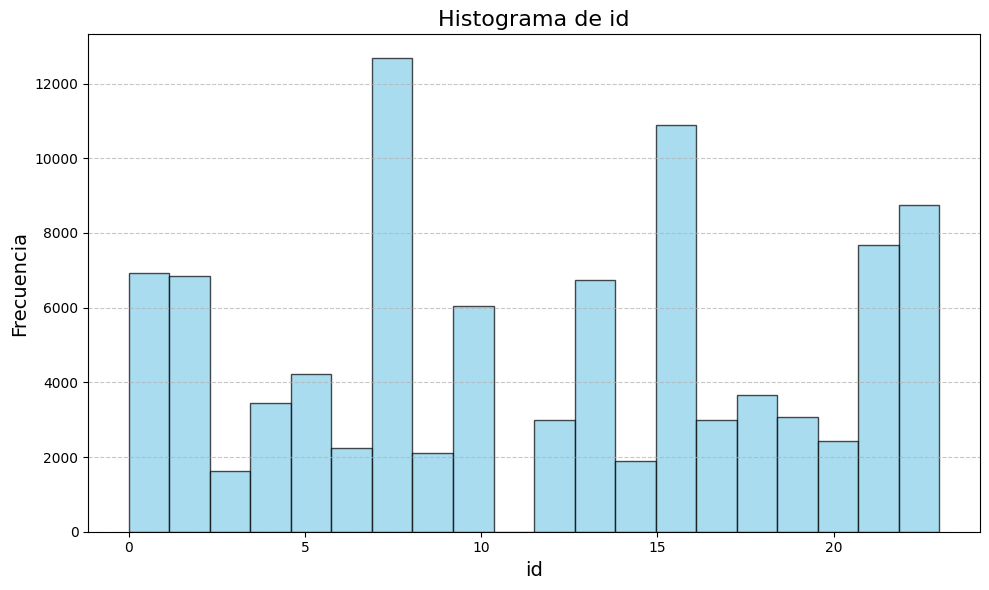

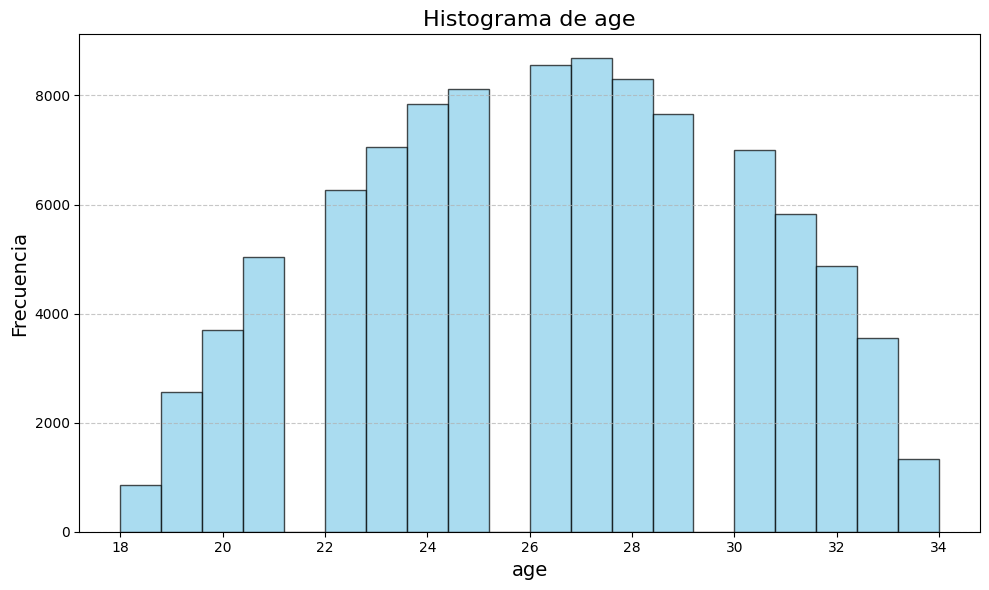

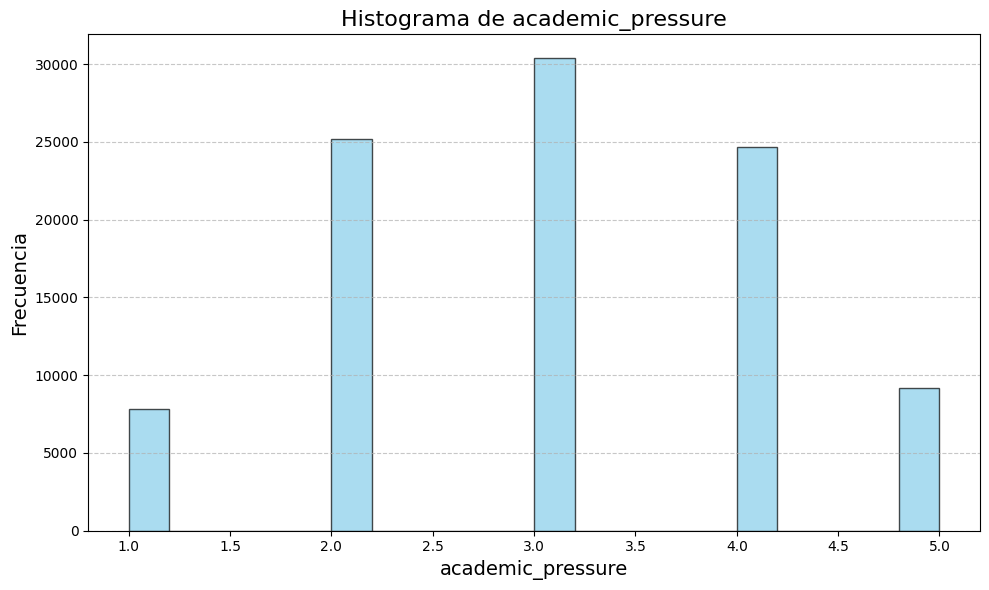

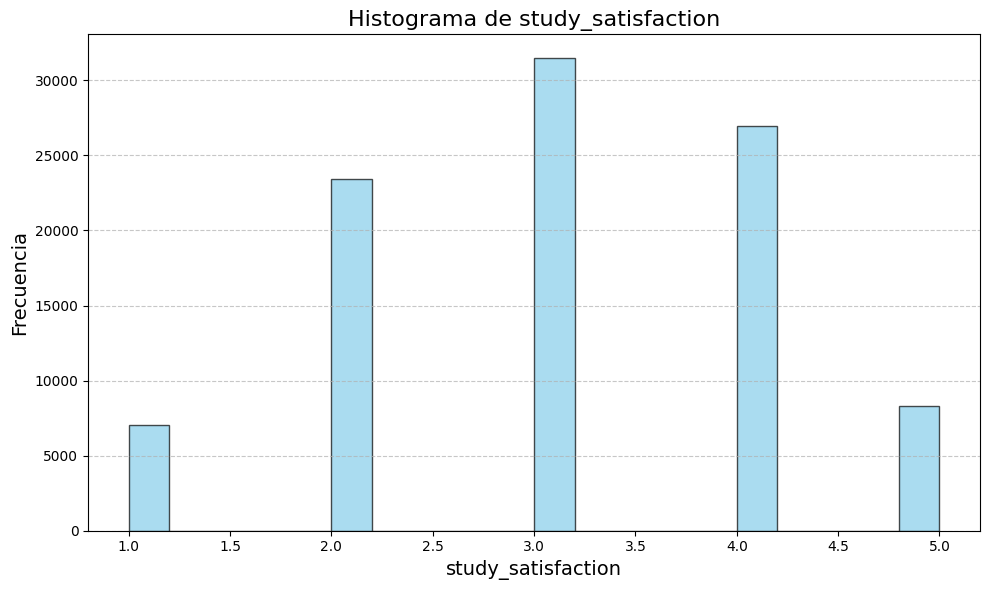

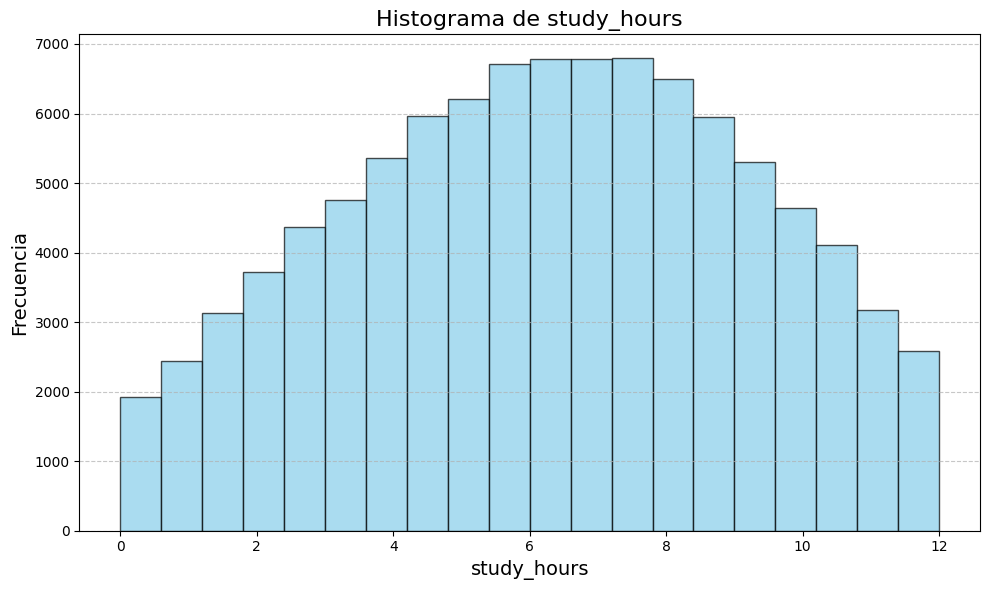

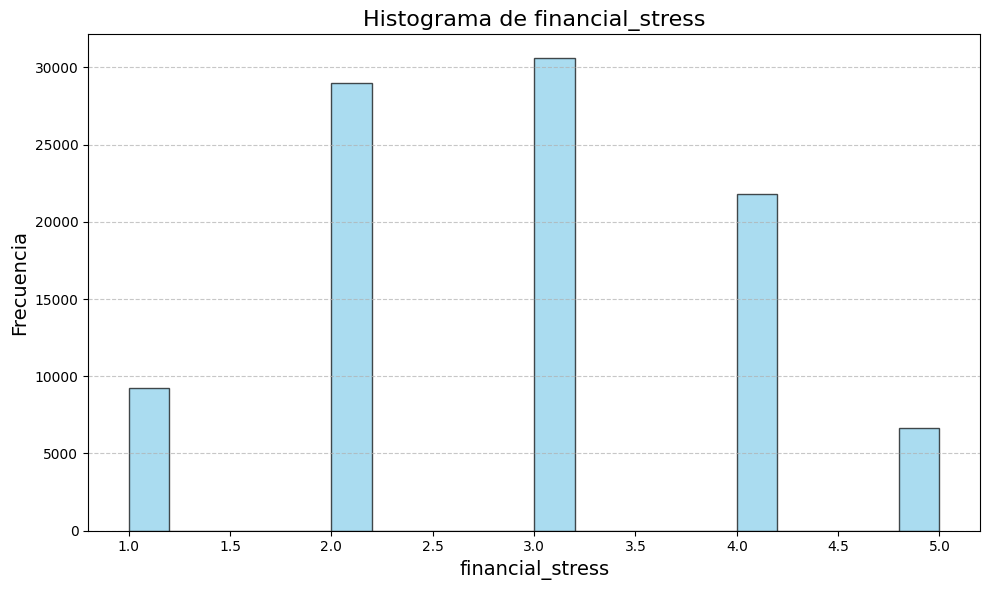

In [78]:
for num_col in final_num_cols.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(final[num_col], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

    plt.title(f'Histograma de {num_col}', fontsize=16)
    plt.xlabel(f'{num_col}', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

**Análisis:** Después de ampliar el dataset original de 502 registros a más de 97 mil, los números en general siguen una línea bastante parecida. Las medias, los mínimos y máximos de variables como la edad, la presión académica, la satisfacción con los estudios y el estrés financiero se mantienen dentro de rangos lógicos. Esto es bueno porque significa que la ampliación respetó el comportamiento original de los datos.

## Distribuciones de las categorías principales

In [79]:
final_cat_cols = []

for c in final.columns:
    if final[c].dtype == 'object':
        final_cat_cols.append(c)

final_cat_cols

['dietary_habits', 'suicidal_thoughts', 'family_history', 'depression']

## Visualización de correlación entre variables

In [80]:
chi2_results = {}
for col in final_cat_cols:
    contingency = pd.crosstab(final[col], final['depression'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results[col] = {'chi2': chi2, 'p_value': p}

chi2_df = pd.DataFrame(chi2_results)
chi2_df

,dietary_habits,suicidal_thoughts,family_history,depression
chi2,4454.767994,24943.582778,3.104785e+02,97232.997363
p_value,0.000000,0.000000,1.717890e-69,0.000000


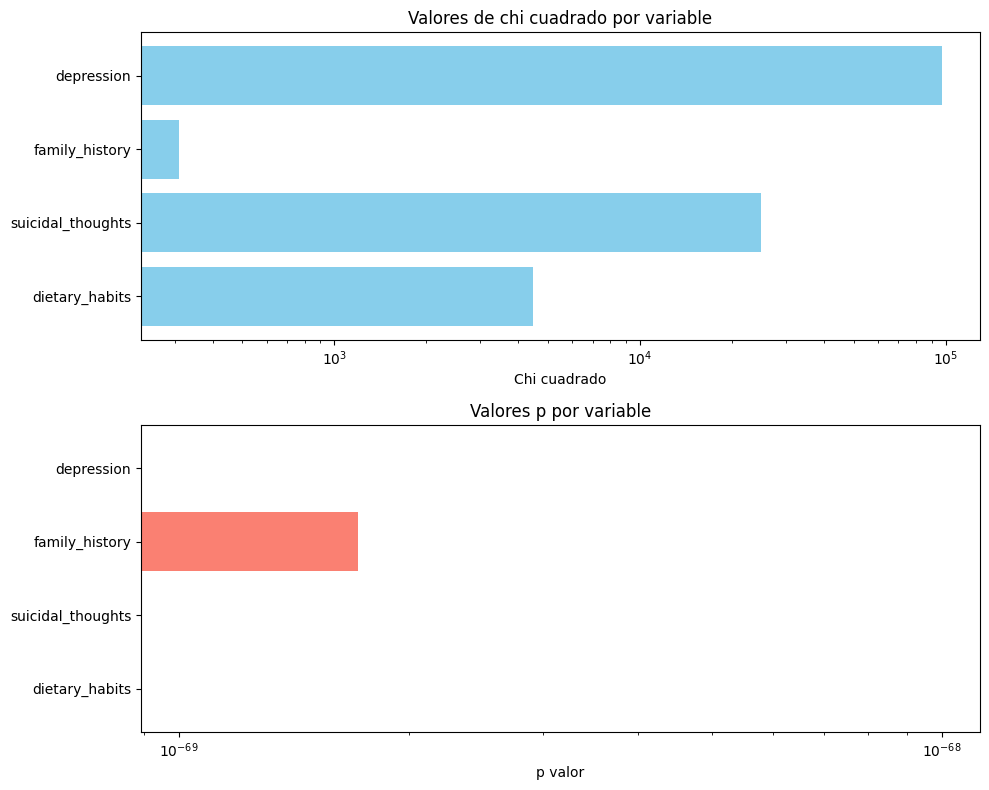

In [81]:
variables = [x[0] for x in chi2_results.items()]
p_values = [x[1]['p_value'] for x in chi2_results.items()]
chi2_values = [x[1]['chi2'] for x in chi2_results.items()]

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].barh(variables, chi2_values, color='skyblue')
ax[0].set_title('Valores de chi cuadrado por variable')
ax[0].set_xlabel('Chi cuadrado')
ax[0].set_xscale('log')

ax[1].barh(variables, p_values, color='salmon')
ax[1].set_title('Valores p por variable')
ax[1].set_xlabel('p valor')
ax[1].set_xscale('log')

plt.tight_layout()
plt.show()

Las gráficas muestran qué variables están más asociadas con la depresión según la prueba de Chi-cuadrado. Suicidal_thoughts, dietary_habits y family_history tienen una fuerte relación con la depresión, pero ahora, menos variables resultan estadísticamente significativas. Esto sugiere que hubo cambios en los datos o en el umbral de significancia, lo que podría haber reducido la cantidad de variables consideradas relevantes.

Podemos observar que la ampliación del conjunto de datos ha influido directamente en la distribución de las variables numéricas, las cuales, al expandirse, tienden a adoptar una forma más cercana a la distribución normal, en contraste con el comportamiento observado en el conjunto de datos original.

Aún así no se observan cambios significativos en los valores estadisticos, donde estos o se mantienen completamente igual o se acercan mucho. 

# 5. Informe Final
Documenten cada uno de los pasos seguidos en un informe en Jupyter Notebook.
Incluir en el informe:
- Dataset original y sus características principales.
- EDA del dataset original y análisis.
- Descripción del proceso de simulación.
- EDA del dataset expandido y análisis comparativo.
- Conclusiones sobre la efectividad de la simulación para aumentar la cantidad de datos sin alterar significativamente sus propiedades estadísticas.

## Conclusiones

Al comparar tanto el conjunto de datos original como el extendido, se observa que ambas muestras conservan distribuciones y relaciones estadísticas consistentes. Esto indica que los parámetros clave como los valores mínimos, máximos, promedios y desviaciones estándar se mantienen intactos, lo cual sugiere que el proceso de expansión se realizó de manera apropiada. Como resultado, podemos estar seguros de que la simulación no ha alterado las características fundamentales del dataset. En consecuencia, el conjunto de datos ampliado es perfectamente válido para realizar análisis adicionales, ya que refleja fielmente las distribuciones del conjunto original, pero con una mayor cantidad de datos, lo que fortalece la fiabilidad de cualquier análisis posterior.